# [ LG전자_DIC ] 시계열 데이터 시각화

## t-SNE를 활용한 representation 시각화

### 강의 복습
강의자료 : 시계열 데이터 시각화

- t-SNE : 가까운 이웃 객체들과의 거리 정보를 잘 보존하는 것이 멀리 떨어진 객체들과의 거리 정보를 보존하는 것보다 더 중요함을 가정으로 local pairwise distance를 확정적(deterministic)이 아닌 확률적(probabilistic)으로 정의함

<img src="./image/tsne01.png" width="400">

### 실습 요약
1. 본 실습에서는 t-SNE를 활용하여 representation 시각화를 진행합니다. 
2. 이전에 실습한 RNN 계열 분류 모델을 학습하고 각 모델의 representation을 시각화하여 분류 성능을 확인합니다.

---

### STEP 0. 환경 구축하기
- 필요한 library들을 import 합니다.

In [1]:
# github에서 데이터 불러오기
# !git clone https://github.com/hwk0702/2024_LGE_TSVisulaization.git
# %cd 2024_LGE_TSVisulaization

In [2]:
import os  # 운영 체제와 상호 작용하기 위한 모듈
import sys  # 시스템 관련 정보에 접근하기 위한 모듈
import random  # 난수 생성과 관련된 함수를 제공하는 모듈
import numpy as np  # 다차원 배열과 연산을 다루는 모듈
import pandas as pd  # 데이터 조작 및 분석을 위한 모듈
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 모듈
import seaborn as sns  # matplotlib 기반으로, 통계적 그래픽을 그리기 위한 고급 인터페이스 제공
import math  # C 표준에 의해 정의된 수학 함수에 접근 가능
from tqdm.auto import tqdm  # 반복 실행을 위한 진행 상태 바 제공 (auto는 노트북과 터미널 환경 자동 처리)
from collections import defaultdict  # 누락된 값에 대해 팩토리 함수를 호출하는 딕셔너리 서브클래스 구현

import torch  # 머신 러닝 알고리즘을 위한 광범위한 지원을 갖춘 과학 계산 프레임워크
import torch.nn as nn  # 신경망 생성 및 훈련을 돕는 모듈
import torch.nn.functional as F  # 계층/활성화 함수 및 손실 계산 함수를 포함
from torch.utils.data import Dataset, DataLoader  # 데이터를 데이터셋 객체로 감싸고 미니 배치 형태로 로드하기 위한 유틸리티
from torch.optim import AdamW  # Adam의 변형인 AdamW 최적화 알고리즘 구현, 다른 가중치 감소 방식 사용

from sklearn.model_selection import train_test_split  # 데이터 배열을 훈련 데이터와 테스트 데이터로 나누기 위한 유틸리티 함수
from sklearn.metrics import precision_recall_curve  # 다양한 확률 임계값에 대해 정밀도-재현율 쌍을 계산
from sklearn.metrics import classification_report, confusion_matrix  # 분류 알고리즘의 예측 품질 측정 도구
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score  # 다양한 분류 메트릭 계산 함수

import warnings  # 경고 메시지를 관리하기 위한 모듈
warnings.filterwarnings("ignore")  # 경고 메시지를 무시하도록 설정

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0]].
PyTorch version:[1.7.1].
device:[cuda:0].


In [3]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    
random_seed = 42
torch_seed(random_seed)

### STEP 1. 데이터 준비하기
이번 실습에서는 ECG Heartbeat Categorization 데이터를 활용하여 시계열 분류를 진행합니다.

- MIT-BIH 부정맥 데이터셋과 PTB 진단 심전도 데이터베이스에서 파생된 두 개의 심장 박동 신호 컬렉션으로 구성되어 있음
- 실습에서는 MIT-BIH 부정맥 데이터셋 사용
- 정상적인 경우와 다양한 부정맥 및 심근경색의 영향을 받은 경우의 심전도(ECG) 형태의 심장 박동을 제공
- 데이터셋 출처
    - https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data

| Name       | Description                             |
|-------------------|-----------------------------------------|
| Number of Samples | 109446 |
| Number of Categories | 5 |
| Sampling Frequency | 125Hz |
| Data Source | Physionet's MIT-BIH Arrhythmia Dataset |
| Classes | ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4] |

In [4]:
# !pip install gdown
import gdown

train_url1 = 'https://drive.google.com/uc?id=1iomPOwLtgQFSdeYaAgNL8mo05nrLz7V4'
train_file1 = './data/mitbih_train1.csv'  
gdown.download(train_url1, train_file1, quiet=False)

train_url2 = 'https://drive.google.com/uc?id=10WPBh1zIXFQP2oWmLpz8XPtzKj2VCtdu'
train_file2 = './data/mitbih_train2.csv'  
gdown.download(train_url2, train_file2, quiet=False)

train_url3 = 'https://drive.google.com/uc?id=1E7a737hYLl6JO-0Wi3BMSf_DyMUVZY_Y'
train_file3 = './data/mitbih_train3.csv'  
gdown.download(train_url3, train_file3, quiet=False)

test_url = 'https://drive.google.com/uc?id=1dGblyAqCgfCjRp5ZK6JVX7geYlMx52e1'
test_file = './data/mitbih_test.csv'  
gdown.download(test_url, test_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1iomPOwLtgQFSdeYaAgNL8mo05nrLz7V4
To: /tf/dsba/External_Lecture/2024/2024_LGE_TSVisulaization/data/mitbih_train1.csv
100%|██████████| 70.7M/70.7M [00:02<00:00, 30.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=10WPBh1zIXFQP2oWmLpz8XPtzKj2VCtdu
To: /tf/dsba/External_Lecture/2024/2024_LGE_TSVisulaization/data/mitbih_train2.csv
100%|██████████| 70.8M/70.8M [00:01<00:00, 37.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E7a737hYLl6JO-0Wi3BMSf_DyMUVZY_Y
To: /tf/dsba/External_Lecture/2024/2024_LGE_TSVisulaization/data/mitbih_train3.csv
100%|██████████| 71.6M/71.6M [00:01<00:00, 37.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dGblyAqCgfCjRp5ZK6JVX7geYlMx52e1
To: /tf/dsba/External_Lecture/2024/2024_LGE_TSVisulaization/data/mitbih_test.csv
100%|██████████| 103M/103M [00:04<00:00, 25.5MB/s] 


'./data/mitbih_test.csv'

In [7]:
df1 = pd.read_csv('./data/mitbih_train1.csv')
df2 = pd.read_csv('./data/mitbih_train2.csv')
df3 = pd.read_csv('./data/mitbih_train3.csv')

# 세 데이터프레임을 하나로 결합
train_df = pd.concat([df1, df2, df3], ignore_index=True)
train_df.columns = [int(col) for col in train_df.columns]
test_df = pd.read_csv('./data/mitbih_test.csv',header=None)

In [8]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [6]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [7]:
# 마지막 열이 target
target_column_index = train_df.shape[1] - 1

# target 고유 값 가져오기
class_labels = train_df[target_column_index].unique()

# 도메인 지식을 기반으로 클래스 레이블의 이름 지정
class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

for label in class_labels:
    print(f"Class label {int(label)}: {class_names[label]}")

Class label 0: Normal Beats
Class label 1: Supraventricular Ectopy Beats
Class label 2: Ventricular Ectopy Beats
Class label 3: Fusion Beats
Class label 4: Unclassifiable Beats


### STEP 2. 데이터 EDA 

In [8]:
train_df[target_column_index] = train_df[target_column_index].astype(int)
test_df[target_column_index] = test_df[target_column_index].astype(int)
train_value_counts = train_df[target_column_index].value_counts().sort_index()
test_value_counts = test_df[target_column_index].value_counts().sort_index()

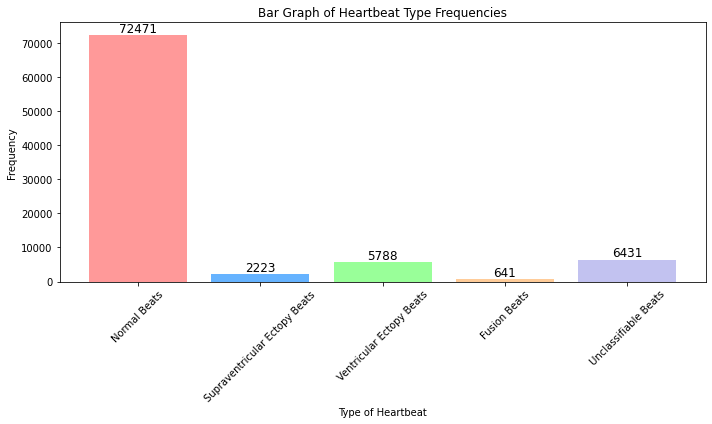

In [9]:
train_value_counts.index = train_value_counts.index.map(class_names)


colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(train_value_counts.index, train_value_counts.values, color=colors)

# 각 바 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=12)

plt.xlabel('Type of Heartbeat')
plt.ylabel('Frequency')
plt.title('Bar Graph of Heartbeat Type Frequencies')
plt.xticks(rotation=45)  # 레이블 회전
plt.tight_layout()  # 레이블이 잘리지 않도록 조정
plt.show()

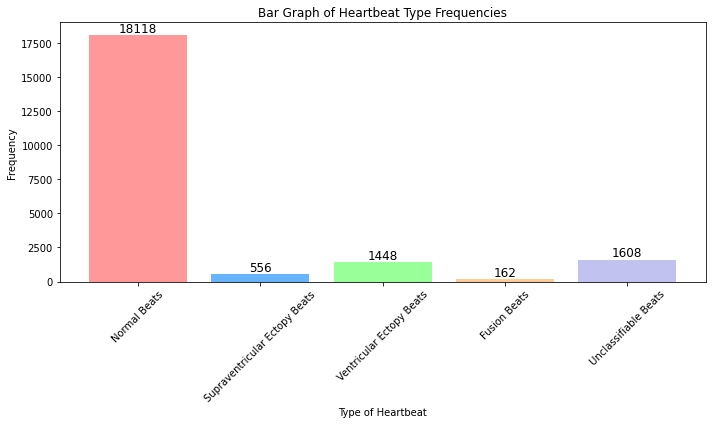

In [10]:
test_value_counts.index = test_value_counts.index.map(class_names)


colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(test_value_counts.index, test_value_counts.values, color=colors)

# 각 바 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=12)

plt.xlabel('Type of Heartbeat')
plt.ylabel('Frequency')
plt.title('Bar Graph of Heartbeat Type Frequencies')
plt.xticks(rotation=45)  # 레이블 회전
plt.tight_layout()  # 레이블이 잘리지 않도록 조정
plt.show()

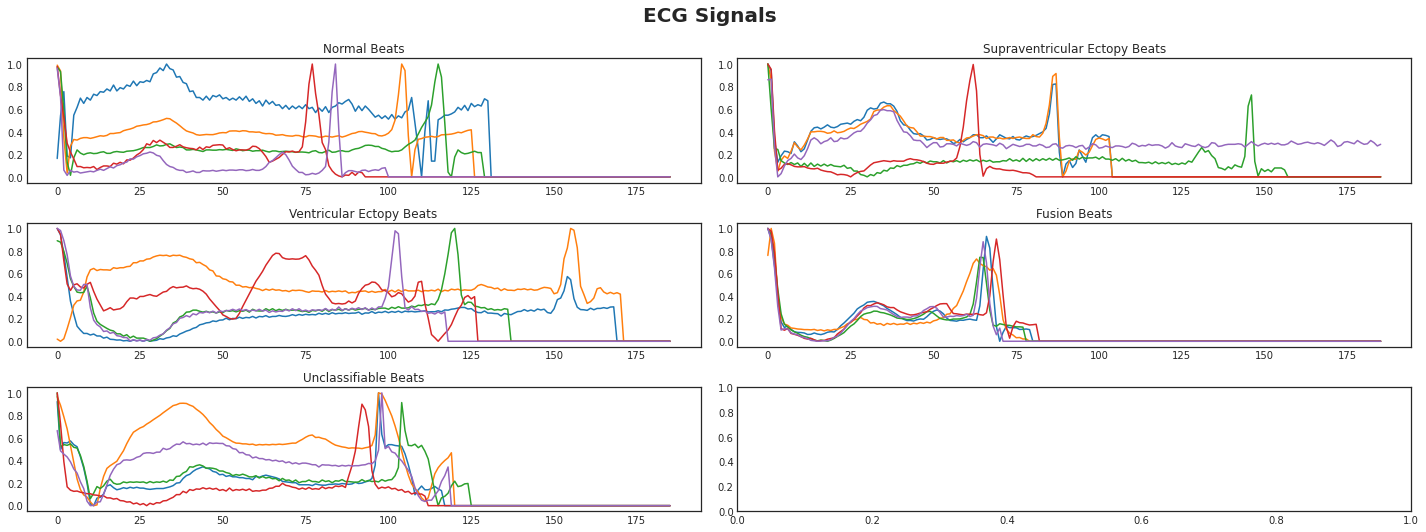

In [11]:
N = 5
samples = [train_df.loc[train_df[target_column_index] == cls].sample(N) for cls in range(N)]
titles = [class_names[cls] for cls in range(5)]

with plt.style.context("seaborn-white"):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
plt.show()

### STEP 3. 데이터 전처리 및 loader 생성 

In [12]:
X_train = train_df.drop(columns = [target_column_index])
y_train = train_df[target_column_index]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Separate features and target variable for test dataset
X_test = test_df.drop(columns=[187])
y_test = test_df[187]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_normalized = scaler.fit_transform(X_train)
# Transform the valid data using the fitted scaler
X_valid_normalized = scaler.transform(X_valid)
# Transform the test data using the fitted scaler
X_test_normalized = scaler.transform(X_test)

print("Before Normalization:")
print(X_train.head(5))

print("After Normalization:")
print(X_train_normalized[:, 5])

Before Normalization:
            0         1         2         3         4         5         6    \
14872  0.053191  0.162234  0.292553  0.441489  0.521277  0.627660  0.747340   
50486  0.974265  0.867647  0.591912  0.312500  0.128676  0.022059  0.000000   
84864  0.752322  0.637771  0.540248  0.411765  0.272446  0.151703  0.086687   
71041  0.977654  0.916201  0.614525  0.364991  0.327747  0.294227  0.240223   
78758  0.015464  0.000000  0.033505  0.108247  0.203608  0.269330  0.349227   

            7         8         9    ...  177  178  179  180  181  182  183  \
14872  0.784574  0.779255  0.795213  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
50486  0.014706  0.044118  0.055147  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
84864  0.023220  0.024768  0.043344  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
71041  0.210428  0.178771  0.152700  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
78758  0.444588  0.511598  0.600515  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       184  185  186  
14872

In [14]:
class ECGDataset(Dataset):

    def __init__(self, X, Y):
        self.signals = X
        self.targets = np.array(Y)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        signal = torch.FloatTensor(signal) 
        signal = torch.unsqueeze(signal, 1)
        target = torch.tensor(self.targets[idx])
        return signal, target

    def __len__(self):
        return len(self.signals)

In [15]:
train_dataset = ECGDataset(X_train_normalized, y_train)
valid_dataset = ECGDataset(X_valid_normalized, y_valid)
test_dataset = ECGDataset(X_test_normalized, y_test)

In [16]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, drop_last=True)

In [17]:
inputs, targets = next(iter(train_loader))
print('inputs.shape: ', inputs.shape)
print('targets: ', targets)

inputs.shape:  torch.Size([128, 187, 1])
targets:  tensor([0, 0, 4, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 0, 2, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 2, 0, 0,
        0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 4, 2, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


### STEP 4. 모델 빌드

In [18]:
class VanillaModel(nn.Module):
    def __init__(
        self,
        module_type: str,
        input_dim: int,
        hidden_dim: int,
        num_layers: int,
        num_classes: int,
        is_attention: bool = False
      ):
        super(VanillaModel, self).__init__()

        # check module type
        self.module_type = module_type
        module_list = ['RNN', 'LSTM', 'GRU']
        assert self.module_type in module_list, 'module_type is not in {}'.format(module_list)

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.encoder = getattr(nn, module_type)(
            input_size  = input_dim,
            hidden_size = hidden_dim,
            num_layers  = num_layers,
            batch_first = True
          )

        self.clf = nn.Linear(in_features=hidden_dim, out_features=num_classes)

    def forward(self, x, return_rep: bool = False):
        bs, _, _ = x.shape # (batch size x time length(sequence) x features)

        # Initialize hidden and cell states (num_layers x batch size x dim)
        h0 = torch.zeros(self.num_layers, bs, self.hidden_dim, device=x.device)

        if self.module_type == 'LSTM':
          c0 = torch.zeros(self.num_layers, bs, self.hidden_dim, device=x.device)
          states = (h0, c0)
        elif self.module_type in ['RNN', 'GRU']:
          states = h0

        # encoding
        out, states = self.encoder(x, states)

        # last output
        out_last = out[:, -1, :]

        # Decode the hidden state of the last time step
        out = self.clf(out_last)

        if return_rep:
            return out, out_last
        else:
            return out

In [19]:
# Instantiate the RNN model
model_rnn = VanillaModel(module_type='RNN', input_dim=1, hidden_dim=32, num_layers=2, num_classes=5).to(device)
model_rnn

VanillaModel(
  (encoder): RNN(1, 32, num_layers=2, batch_first=True)
  (clf): Linear(in_features=32, out_features=5, bias=True)
)

In [20]:
!pip install torchinfo
from torchinfo import summary
summary(model_rnn, (128, 187, 1))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaModel                             --                        --
├─RNN: 1-1                               [128, 187, 32]            3,232
├─Linear: 1-2                            [128, 5]                  165
Total params: 3,397
Trainable params: 3,397
Non-trainable params: 0
Total mult-adds (M): 77.38
Input size (MB): 0.10
Forward/backward pass size (MB): 6.13
Params size (MB): 0.01
Estimated Total Size (MB): 6.24

In [21]:
outputs = model_rnn(inputs.to(device))
outputs.shape

torch.Size([128, 5])

### STEP 5. 학습

In [22]:
class EarlyStopping:
    """
    early stopping

    Parameters
    ----------
    patience : int
    verbose : bool

    Methods
    -------
    validate(loss)
    """
    def __init__(self, patience: int = 0, verbose: bool = 0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [23]:
def train(model, trainloader, optimizer, criterion):
    # train mode
    model.train()

    # device
    device = next(iter(model.parameters())).device

    # results
    correct = 0
    total = 0
    total_loss = 0

    # progress
    pbar = tqdm(trainloader, total=len(trainloader), desc="[TRAIN]", leave=False)
    
    # training
    for batch_i, batch in enumerate(pbar):
        inputs, targets = batch

        # device
        inputs, targets = inputs.to(device), targets.to(device)

        # outputs
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # compute gradients
        loss.backward()

        # update model parameters using optimizer
        optimizer.step()
        optimizer.zero_grad()

        # accuracy
        preds_values, preds_cls = outputs.max(dim=1)
        correct_i = targets.eq(preds_cls).sum().item()
        len_i = inputs.size(0)

        correct += correct_i
        total += len_i

        acc = correct_i / len_i

        # update progress
        pbar.set_description(desc="[TRAIN]: Loss: {loss:7.4f} ({loss_avg:7.4f}) ACC: {acc:.2%} ({acc_avg:.2%}) [{correct:}/{total:}]".format(
            loss     = loss,
            loss_avg = total_loss / (batch_i+1),
            acc      = acc,
            acc_avg  = correct/total,
            correct  = correct,
            total    = total
        ))

    return {
        'loss' : total_loss / len(trainloader),
        'acc'  : correct / total
    }

def test(model, testloader, criterion):
    # evaluation mode
    model.eval()

    # device
    device = next(iter(model.parameters())).device

    # results
    correct = 0
    total = 0
    total_loss = 0

    # progress
    pbar = tqdm(testloader, total=len(testloader), desc="[TEST]", leave=False)

    # evaluation
    with torch.no_grad():
        for batch_i, batch in enumerate(pbar):
            inputs, targets = batch

            # device
            inputs, targets = inputs.to(device), targets.to(device)

            # outputs
            outputs = model(inputs)

            # loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # accuracy
            preds_values, preds_cls = outputs.max(dim=1)
            correct_i = targets.eq(preds_cls).sum().item()
            len_i = inputs.size(0)

            correct += correct_i
            total += len_i

            acc = correct_i / len_i

            # update progress
            pbar.set_description(desc="[TEST]: Loss: {loss:7.4f} ({loss_avg:7.4f}) ACC: {acc:.2%} ({acc_avg:.2%}) [{correct:}/{total:}]".format(
                loss     = loss,
                loss_avg = total_loss / (batch_i+1),
                acc      = acc,
                acc_avg  = correct/total,
                correct  = correct,
                total    = total
            ))

    return {
        'loss' : total_loss / len(testloader),
        'acc'  : correct / total
    }

def fit(model, epochs, trainloader, validloader, criterion, optimizer, scheduler, savedir: str, patience: int = 10, verbose: bool = False, seed: int = 223):
    torch_seed(seed)

    # make save directory
    os.makedirs(savedir, exist_ok=True)

    # history
    history = {'train': defaultdict(list), 'valid': defaultdict(list)}
    best_acc = 0

    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # progress bar
    pbar = tqdm(range(epochs), total=epochs)
    for i in pbar:

        # train
        train_results = train(
            model       = model,
            trainloader = trainloader,
            criterion   = criterion,
            optimizer   = optimizer
        )
        
        # valid
        valid_results = test(
            model      = model,
            testloader = validloader,
            criterion  = criterion
        )

        # update scheduler
        scheduler.step()

        # update progress
        pbar.set_description(desc="[TRAIN] Loss: {loss_train:>7.4f} Acc: {acc_train:.2%} [TEST] Loss: {loss_valid:>7.4f} Acc: {acc_valid:.2%}".format(
            loss_train = train_results['loss'],
            acc_train  = train_results['acc'],
            loss_valid  = valid_results['loss'],
            acc_valid   = valid_results['acc']
        ))

        # append history
        for k, v in train_results.items():
            history['train'][k].append(v)

        for k, v in valid_results.items():
            history['valid'][k].append(v)

        # save best model
        if best_acc < valid_results['acc']:
            torch.save(model.state_dict(), os.path.join(savedir, 'best_model.pt'))
            
        if early_stopping.validate(valid_results['loss']):
                print("Early stopping")
                break

    # save results
    json.dump(history, open(os.path.join(savedir, 'history.json'), 'w'), indent='\t')

    return history

def history_plot(history: dict):
    # train history table
    df_train_history = pd.DataFrame(history['train'])
    df_train_history['epoch'] = range(len(df_train_history))
    df_train_history['split'] = 'train'

    # valid history table
    df_valid_history = pd.DataFrame(history['valid'])
    df_valid_history['epoch'] = range(len(df_valid_history))
    df_valid_history['split'] = 'valid'
    df_history = pd.concat([df_train_history, df_valid_history], axis=0, ignore_index=True)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    for i, m in enumerate(['acc', 'loss']):
        sns.lineplot(
            x    = 'epoch',
            y    = m,
            hue  = 'split',
            data = df_history,
            ax   = ax[i]
        )
        ax[i].set_ylabel(m.upper())
    plt.tight_layout()
    plt.show()

In [24]:
epochs = 100
lr = 1e-3
eta_min = lr * 1e-2
seed = 42

In [25]:
# Instantiate the RNN model
model_rnn = VanillaModel(module_type='RNN', input_dim=1, hidden_dim=32, num_layers=2, num_classes=5)
model_lstm = VanillaModel(module_type='LSTM', input_dim=1, hidden_dim=32, num_layers=2, num_classes=5)
model_gru = VanillaModel(module_type='GRU', input_dim=1, hidden_dim=32, num_layers=2, num_classes=5)

print('RNN parameters: {:,}'.format(sum([p.numel() for p in model_rnn.parameters()])))
print('LSTM parameters: {:,}'.format(sum([p.numel() for p in model_lstm.parameters()])))
print('GRU parameters: {:,}'.format(sum([p.numel() for p in model_gru.parameters()])))

model_rnn.to(device)
model_lstm.to(device)
model_gru.to(device)
print('convert device to GPU')

RNN parameters: 3,397
LSTM parameters: 13,093
GRU parameters: 9,861
convert device to GPU


In [26]:
# optimizer
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=lr)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=lr)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=lr)

scheduler_rnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_rnn, T_max=epochs, eta_min=eta_min)
scheduler_lstm = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_lstm, T_max=epochs, eta_min=eta_min)
scheduler_gru = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gru, T_max=epochs, eta_min=eta_min)

# loss function
criterion = nn.CrossEntropyLoss()

RNN


  0%|          | 0/100 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

Early stopping


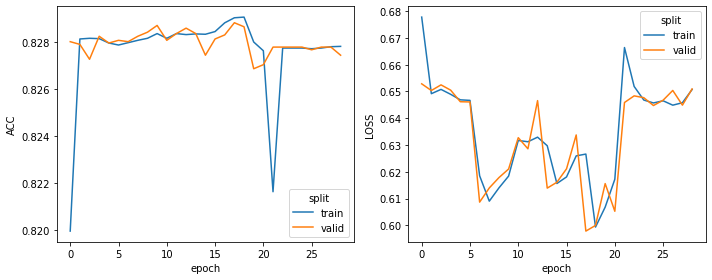

LSTM


  0%|          | 0/100 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

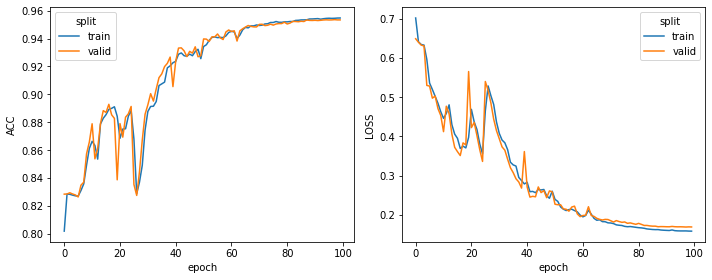

GRU


  0%|          | 0/100 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/547 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/136 [00:00<?, ?it/s]

Early stopping


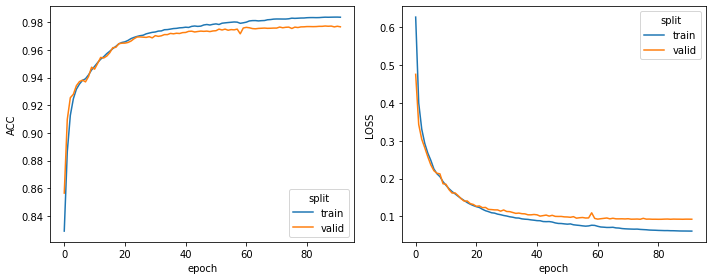

In [27]:
print('RNN')
rnn_history = fit(
    model       = model_rnn,
    epochs      = epochs,
    trainloader = train_loader,
    validloader  = valid_loader,
    criterion   = criterion,
    optimizer   = optimizer_rnn,
    scheduler   = scheduler_rnn,
    savedir     = 'saved_model/RNN',
    seed        = seed
)
history_plot(history=rnn_history)

print('LSTM')
lstm_history = fit(
    model       = model_lstm,
    epochs      = epochs,
    trainloader = train_loader,
    validloader  = valid_loader,
    criterion   = criterion,
    optimizer   = optimizer_lstm,
    scheduler   = scheduler_lstm,
    savedir     = 'saved_model/LSTM',
    seed        = seed
)
history_plot(history=lstm_history)

print('GRU')
gru_history = fit(
    model       = model_gru,
    epochs      = epochs,
    trainloader = train_loader,
    validloader  = valid_loader,
    criterion   = criterion,
    optimizer   = optimizer_gru,
    scheduler   = scheduler_gru,
    savedir     = 'saved_model/GRU',
    seed        = seed
)
history_plot(history=gru_history)


In [28]:
model_rnn.load_state_dict(torch.load('./saved_model/RNN/best_model.pt'))
model_lstm.load_state_dict(torch.load('./saved_model/LSTM/best_model.pt'))
model_gru.load_state_dict(torch.load('./saved_model/GRU/best_model.pt'))

<All keys matched successfully>

### STEP 6. 테스트

In [29]:
# test
rnn_test_results = test(
    model      = model_rnn,
    testloader = test_loader,
    criterion  = criterion
)
print('RNN Accuracy: {:.2%}'.format(rnn_test_results['acc']))

# test
lstm_test_results = test(
    model      = model_lstm,
    testloader = test_loader,
    criterion  = criterion
)
print('LSTM Accuracy: {:.2%}'.format(lstm_test_results['acc']))

# test
gru_test_results = test(
    model      = model_gru,
    testloader = test_loader,
    criterion  = criterion
)
print('GRU Accuracy: {:.2%}'.format(gru_test_results['acc']))

[TEST]:   0%|          | 0/171 [00:00<?, ?it/s]

RNN Accuracy: 82.69%


[TEST]:   0%|          | 0/171 [00:00<?, ?it/s]

LSTM Accuracy: 95.17%


[TEST]:   0%|          | 0/171 [00:00<?, ?it/s]

GRU Accuracy: 97.57%


### STEP 7. Representation 시각화 (t-SNE)

In [30]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

def test_rep(model, testloader):
    # evaluation mode
    model.eval()

    # device
    device = next(iter(model.parameters())).device

    # results
    all_reps = []
    all_targets = []
    correct = 0
    total = 0

    # progress
    pbar = tqdm(testloader, total=len(testloader), desc="[TEST]", leave=False)

    # evaluation
    with torch.no_grad():
        for batch_i, batch in enumerate(pbar):
            inputs, targets = batch

            # device
            inputs, targets = inputs.to(device), targets.to(device)

            # outputs
            outputs, reps = model(inputs, return_rep=True)
            
            all_reps.append(reps.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())

            # accuracy
            preds_values, preds_cls = outputs.max(dim=1)
            correct_i = targets.eq(preds_cls).sum().item()
            len_i = inputs.size(0)

            correct += correct_i
            total += len_i

            acc = correct_i / len_i

            # update progress
            pbar.set_description(desc="[TEST]: ACC: {acc:.2%} ({acc_avg:.2%}) [{correct:}/{total:}]".format(
                acc      = acc,
                acc_avg  = correct/total,
                correct  = correct,
                total    = total
            ))
            
        all_reps = np.concatenate(all_reps, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

    return all_reps, all_targets

def plot_tsne(all_reps, all_targets, class_names, perplexity=30, n_iter=1000):
    # t-SNE 모델 초기화 및 변환 수행
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(all_reps)
    
    # 결과 시각화
    plt.figure(figsize=(10, 8))
    colors = [
        (0.8, 0.5, 0.5),  
        (0.5, 0.8, 0.5),  
        (0.5, 0.5, 0.8),  
        (0.8, 0.7, 0.4),  
        (0.7, 0.5, 0.8),  
        (0.4, 0.7, 0.8),  
        (0.8, 0.4, 0.5),  
        (0.8, 0.5, 0.6),  
        (0.6, 0.8, 0.5),  
        (0.5, 0.7, 0.7)   
    ]
    cmap = ListedColormap(colors[:len(class_names)])  # 사용할 클래스 수에 맞게 컬러맵 설정
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_targets, cmap=cmap, alpha=0.7)
    
    # 색상 막대 추가
    colorbar = plt.colorbar(scatter, ticks=range(len(class_names)))
    colorbar.set_label('Class Labels')
    colorbar.set_ticklabels([class_names[i] for i in range(len(class_names))])
    
    plt.title('t-SNE visualization of Model Representations')
    plt.xlabel('t-SNE-1')
    plt.ylabel('t-SNE-2')
    plt.grid(True)
    plt.show()

[TEST]:   0%|          | 0/171 [00:00<?, ?it/s]

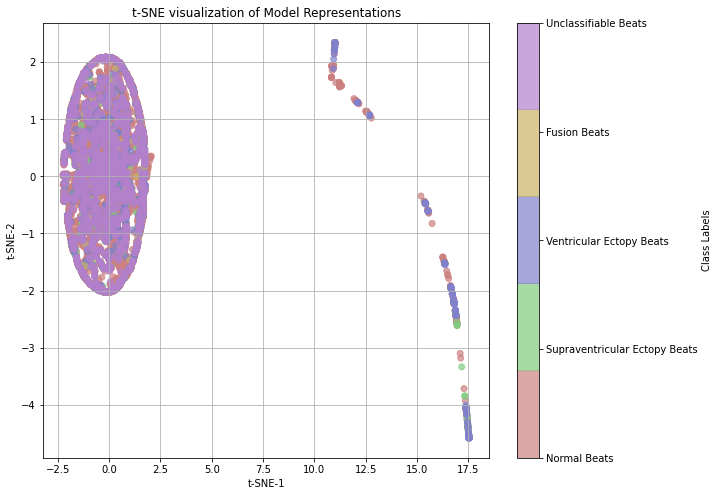

[TEST]:   0%|          | 0/171 [00:00<?, ?it/s]

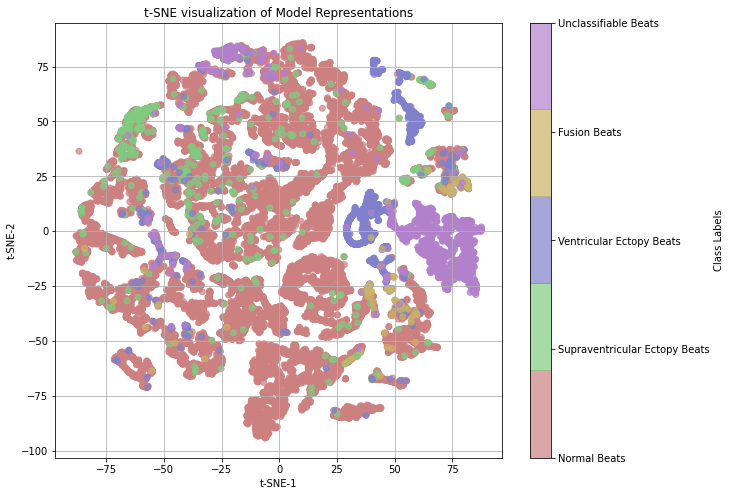

[TEST]:   0%|          | 0/171 [00:00<?, ?it/s]

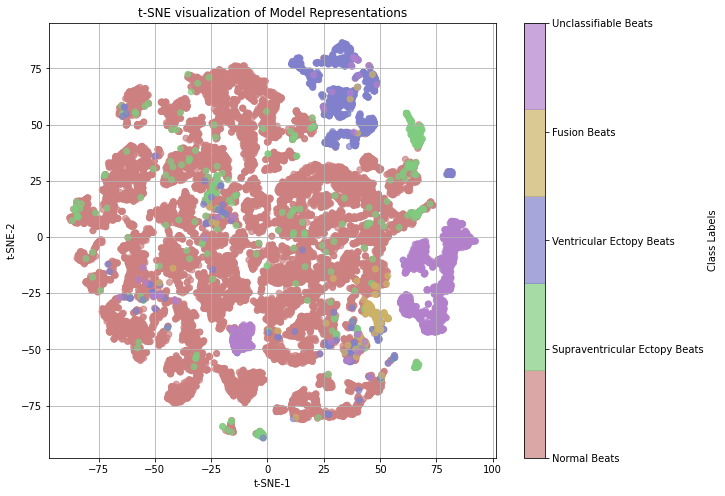

In [31]:
all_rnn_reps, all_rnn_targets = test_rep(model_rnn, test_loader)
plot_tsne(all_rnn_reps, all_rnn_targets, class_names)

all_lstm_reps, all_lstm_targets = test_rep(model_lstm, test_loader)
plot_tsne(all_lstm_reps, all_lstm_targets, class_names)

all_gru_reps, all_gru_targets = test_rep(model_gru, test_loader)
plot_tsne(all_gru_reps, all_gru_targets, class_names)

---